Try again from scratch  

simulated pop: 1000sims_500kpop.npy
  
make ~90k simulated kinship pairs 1000 times?  
matrix of nuts3 by nuts3  

have real kinship pairs  

NUTS1 by NUTS1 matrix for real pairs vs. sim pairs  

NUTS3 by NUTS3 matrix for real pairs vs. sim pairs  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
kinship = pd.read_csv('../prob_of_kin_within_D/kinship_data.csv')
kinship.head(5)

,uniqID,ID1,ID2,HetHet,IBS0,Kinship,pob_north_id1,pob_east_id1,pob_north_id2,pob_east_id2,distance,region1,region2
0,rel1,1000027,3239325,0.078,0.0041,0.2657,422500,438500,425500,442500,5000.000000,UKE45,UKE45
1,rel2,1000064,3178357,0.046,0.0138,0.0682,398500,451500,176500,318500,258791.421805,UKE31,UKL22
2,rel3,1000096,4107632,0.047,0.0137,0.0715,673500,327500,341500,456500,356181.133695,UKM25,UKF14
3,rel4,1000132,2772375,0.055,0.0085,0.1380,255500,427500,255500,427500,0.000000,UKG13,UKG13
4,rel5,1000176,2842606,0.047,0.0131,0.0755,520500,455500,520500,453500,2000.000000,UKC12,UKC12


In [3]:
nuts3_pops = pd.read_csv('../nuts/nuts3_sampling_corrections.csv')
nuts1_pops = pd.read_csv('../nuts/nuts1_sampling_corrections.csv')

In [130]:
nuts1_pops.sort_values(by='NUTS_ID')

,NUTS_ID,ukb_points,census_pops,frac_sampled,weighting
8,UKC,49828,2596885,0.019188,1.000000
10,UKD,74978,7052175,0.010632,1.804721
3,UKE,60351,5283735,0.011422,1.679876
2,UKF,32138,4533220,0.007089,2.706504
6,UKG,41758,5601845,0.007454,2.574021
9,UKH,11998,5846965,0.002052,9.350662
4,UKI,47533,8173940,0.005815,3.299567
1,UKJ,31839,8634750,0.003687,5.203686
7,UKK,31176,5288935,0.005895,3.255132
5,UKL,20995,3063455,0.006853,2.799731


In [133]:
nuts1_weights = nuts1_pops.sort_values(by='NUTS_ID')['weighting'].values
nuts1_weights

array([ 1.        ,  1.80472056,  1.67987627,  2.70650409,  2.5740213 ,
        9.35066234,  3.29956705,  5.20368605,  3.25513178,  2.79973137,
        2.57615507])

In [6]:
len(kinship)

97692

#  make ~97k simulated kinship pairs 1000 times?

In [14]:
# at one point, did a simulated population of 500k people, drawing from nuts3 regions.
# each row in simulated pop = fraction of total population in a nuts3 region
simpop = np.load('1000sims_500kpop.npy')
print(np.shape(simpop))
print(np.sum(simpop[0,:]))

(1000, 134)
1.0


In [7]:
# not really what I want
# instead, draw two regions based on census probabilities to make a pair, and do this X times
# either for nuts1 or nuts3 regions

# do nuts1 first
nuts1_ids = nuts1_pops.sort_values(by='NUTS_ID')['NUTS_ID'].values
nuts1_cf = nuts1_pops.sort_values(by='NUTS_ID')['census_pops'].values / np.sum(nuts1_pops['census_pops'])

# to pick one person (region) based on probability
np.random.choice(nuts1_ids,replace=True,p=nuts1_cf)

'UKG'

In [27]:
# simulate pairs ... takes about 5s for 97k pairs
def sim_pairs(nuts_ids,nuts_cf,numPairs):
    
    sim_regions = np.zeros(2*numPairs)
    num_regions = len(nuts_ids)
    nuts_indices = np.arange(num_regions)
    
    # draw indices of nuts regions
    for sim in range(2 * numPairs):
        sim_regions[sim] = np.random.choice(nuts_indices,replace=True,p=nuts_cf)
      
    nutsInd = dict(zip(nuts_indices,nuts_ids))
    
    # convert indices to nuts names
    sim_regions = list(sim_regions)
    sim_regions = [nutsInd[x] for x in sim_regions]
    
    # make a dictionary of pair counts
    d = {}
    for i in np.arange(0,len(sim_regions),2):
        pair = sorted([sim_regions[i],sim_regions[i+1]])
        k = ','.join(pair)
        if k in d.keys():
            d[k] += 1
        else:
            d[k] = 1 

    return d, sim_regions

In [28]:
def pairdict_to_mat(pairdict,nuts_ids):
    num_regions = len(nuts_ids)
    m = np.zeros((num_regions,num_regions))
    nutsInd = dict(zip(nuts_ids, np.arange(num_regions)))
    for k in pairdict.keys():
        r1,r2 = k.split(',')
        m[nutsInd[r1],nutsInd[r2]] += pairdict[k]
    return(m)

In [29]:
d, sim_regions = sim_pairs(nuts1_ids,nuts1_cf,len(kinship))

In [109]:
ukb_pops = nuts1_pops.sort_values(by='NUTS_ID')['ukb_points'].values
ukb_fracs = ukb_pops / np.sum(ukb_pops)
ukb_fracs

array([ 0.11272411,  0.16962005,  0.13652991,  0.07270465,  0.09446763,
        0.02714265,  0.10753221,  0.07202823,  0.07052835,  0.04749624,
        0.08922597])

In [110]:
print('Census fractions')
for i,id in enumerate(nuts1_ids):
    print(id,nuts1_cf[i])
# from these probabilities, you would expect UKJ/UKJ to be the most common pair, no?
# but it's not . . . UKI/UKJ is most common!?
print('\nTest cases')
print('UKI,UKI',d['UKI,UKI'])
print('UKI,UKJ',d['UKI,UKJ'])
print('UKJ,UKJ',d['UKJ,UKJ'])
print('\nSimulated proportions')
c = {}
for r in sim_regions:
    if r in c.keys():
        c[r] += 1
    else:
        c[r] = 1
nuts1_sim_fracs = []        
for r in sorted(c.keys()):
    print(r,c[r]/float(len(sim_regions)))
    nuts1_sim_fracs.append(c[r]/float(len(sim_regions)))

Census fractions
UKC 0.0423143159238
UKD 0.11490996363
UKE 0.0860945448288
UKF 0.0738654592838
UKG 0.0912779114541
UKH 0.095271960139
UKI 0.133188292706
UKJ 0.140696850043
UKK 0.0861792749739
UKL 0.0499167281911
UKM 0.0862846988275

Test cases
UKI,UKI 0
UKI,UKJ 1287
UKJ,UKJ 0

Simulated proportions
UKC 0.04213241616509028
UKD 0.11518343364860992
UKE 0.08579003398435901
UKF 0.07479629857101912
UKG 0.09088768783523728
UKH 0.09540699340785325
UKI 0.13403349301887565
UKJ 0.13929492691315562
UKK 0.08713098308971051
UKL 0.04884739794456046
UKM 0.08649633542152889


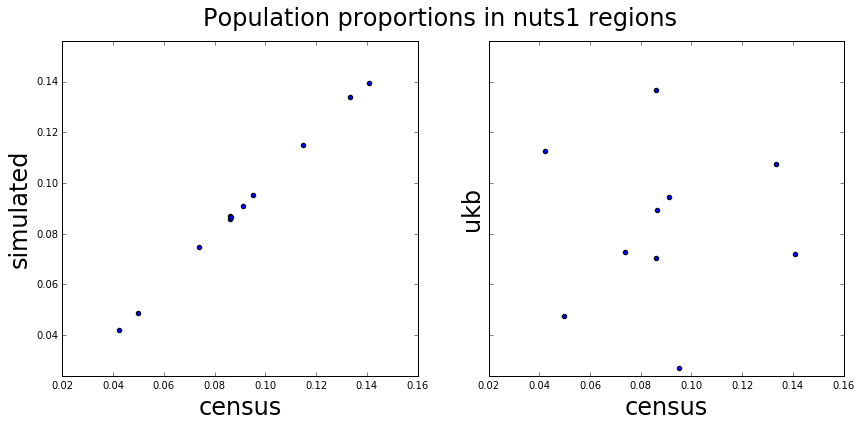

In [111]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (14,6), sharex=True, sharey = True )

ax1.scatter(nuts1_cf,nuts1_sim_fracs)
ax1.set_xlabel('census',fontsize=24)
ax1.set_ylabel('simulated',fontsize=24)
ax1.set_aspect('equal')

ax2.scatter(nuts1_cf,ukb_fracs)
ax2.set_xlabel('census',fontsize=24)
ax2.set_ylabel('ukb',fontsize=24)
ax2.set_aspect('equal')
fig.suptitle('Population proportions in nuts1 regions',fontsize=24)

plt.show()

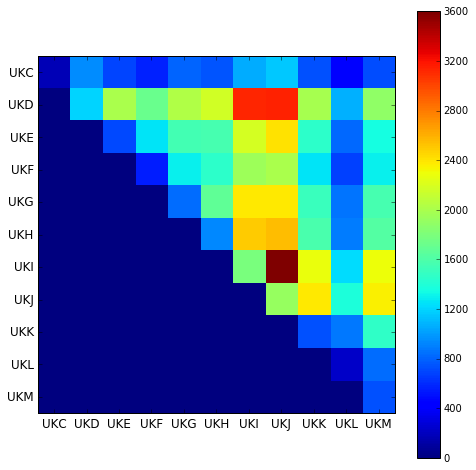

In [46]:
m = pairdict_to_mat(d,nuts1_ids)
fig,ax = plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(m,interpolation='nearest')
ax.set_xticks(np.arange(np.shape(m)[0]))
ax.set_yticks(np.arange(np.shape(m)[0]))
ax.set_xticklabels(nuts1_ids,fontsize=12)
ax.set_yticklabels(nuts1_ids,fontsize=12)
plt.colorbar(im)
plt.show()
plt.show()

In [42]:
def simulate_region_connections(numSims, nuts_ids, nuts_cf, numPairs): 
    m = np.zeros((len(nuts_ids),len(nuts_ids),numSims))
    
    for sim in range(numSims):
    
        d,s = sim_pairs(nuts1_ids,nuts1_cf,numPairs)
        m[:,:,sim] = pairdict_to_mat(d,nuts1_ids)
        
    return m

In [44]:
sim_mat = simulate_region_connections(10, nuts1_ids, nuts1_cf, len(kinship))

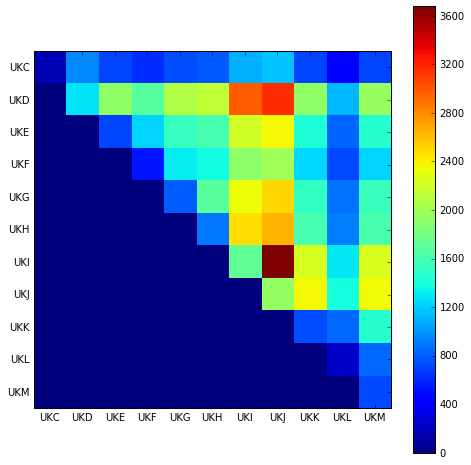

In [45]:
## Simulated connections
mm = np.mean(sim_mat,2)
fig,ax = plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(mm,interpolation='nearest')
ax.set_xticks(np.arange(np.shape(mm)[0]))
ax.set_yticks(np.arange(np.shape(mm)[0]))
ax.set_xticklabels(nuts1_ids)
ax.set_yticklabels(nuts1_ids)
plt.colorbar(im)
plt.show()
# this is surprising ... why is UKI/UKJ most ... why not UKI UKI? See tests above. I don't know.

In [71]:
print(np.shape(m))

(11, 11, 1000)


In [51]:
# for qgis, want csv:
# region1,x1,y1,region2,x2,y2,connections
# 1. convert connections matrix to dictionary pair=>count
# 2. print out csv

# 1. convert connections matrix to dictionary pair=>count
def nuts_matrix_to_dict(m, nuts_ids):
    nuts_ids = sorted(nuts_ids)
    d = {}
    for i in np.arange(len(nuts_ids)):
        region1 = nuts_ids[i]
        for j in np.arange(i,len(nuts_ids)):
            region2 = nuts_ids[j]
            k = ','.join([region1,region2])
            d[k] = m[i,j]
    return d

In [58]:
nuts1_sim_connections_dict = nuts_matrix_to_dict(m, nuts1_ids)

In [60]:
print('Test cases') # looks good.
print('UKI,UKI',nuts1_sim_connections_dict['UKI,UKI'])
print('UKI,UKJ',nuts1_sim_connections_dict['UKI,UKJ'])
print('UKJ,UKJ',nuts1_sim_connections_dict['UKJ,UKJ'])

Test cases
UKI,UKI 1787.0
UKI,UKJ 3600.0
UKJ,UKJ 1923.0


In [56]:
nuts1_centroids = pd.read_csv('nuts1_centroids.csv')
nuts1_centroids

,X,Y,NUTS_ID,NUTS_NAME
0,406294.177291,569223.337055,UKC,North East (England)
1,353013.792259,461751.668628,UKD,North West (England)
2,450743.458406,452364.705629,UKE,Yorkshire and the Humber
3,480296.274210,337095.584610,UKF,East Midlands (England)
4,381704.551781,286827.770398,UKG,West Midlands (England)
5,573324.933398,264295.714506,UKH,East of England
6,531208.767022,179637.217083,UKI,London
7,502537.538208,154526.856816,UKJ,South East (England)
8,319488.205729,122922.782698,UKK,South West (England)
9,279854.826204,271791.586276,UKL,Wales


In [63]:
# print to csv
def save_connections(fname,d,centroids):
    o = open(fname,'w')
    o.write('r1,x1,y1,r2,x2,y2,connections\n')
    for pair in sorted(d.keys()):
        r1,r2 = pair.split(',')
        x1 = centroids[centroids['NUTS_ID']==r1]['X'].values[0]
        y1 = centroids[centroids['NUTS_ID']==r1]['Y'].values[0]
        x2 = centroids[centroids['NUTS_ID']==r2]['X'].values[0]
        y2 = centroids[centroids['NUTS_ID']==r2]['Y'].values[0]
        connections = d[pair]
        toPrint = [str(x) for x in [r1,x1,y1,r2,x2,y2,connections]]
        o.write(','.join(toPrint) + '\n')        

In [64]:
save_connections('nuts1_sim.csv',nuts1_sim_connections_dict,nuts1_centroids)

In [73]:
# make dictionary from kinship file of connections between nuts regions

# then make matrix to visualize (raw, corrected)

# then make csv files for qgis (raw, corrected)
id1,id2 = ['UKE','UKL']
df1=kinship[kinship['region1'].str.contains(id1)]
num12 = len(df1[df1['region2'].str.contains(id2)])
print(num12)

df2 = kinship[kinship['region1'].str.contains(id2)]
num21 = len(df2[df2['region2'].str.contains(id1)])
print(num21)


108
97


In [134]:
# make dictionary from kinship file of connections between nuts regions
# takes about 10s
# wildcard search within columns
# kinship[kinship['region1'].str.contains('UKE')].head(2)

nuts1_weight_dict = dict(zip(nuts1_ids,nuts1_weights))

d = {}
for id1 in sorted(nuts1_ids):
    for id2 in sorted(nuts1_ids):
        k = ','.join(sorted([id1,id2]))
        if id1 != id2:
            df1=kinship[kinship['region1'].str.contains(id1)]
            num12 = len(df1[df1['region2'].str.contains(id2)])
            df2 = kinship[kinship['region1'].str.contains(id2)]
            num21 = len(df2[df2['region2'].str.contains(id1)])
    
            # uncorrected
            # d[k] = num12 + num21 # uncorrected
                            
            # corrections & weights for uneven sampling
            c1 = nuts1_weight_dict[id1]
            c2 = nuts1_weight_dict[id2]
            
            d[k] = c1 * c2 * (num12 + num21) # corrected
                            
        else:
            df1=kinship[kinship['region1'].str.contains(id1)]
            num11 = len(df1[df1['region2'].str.contains(id2)])
            
            # uncorrected
            #d[k] = num11 
            
            # corrections & weights for uneven sampling
            c1 = nuts1_weight_dict[id1]
            d[k] = num11 * c1 * c1

In [136]:
ukb_nuts1_corrected_connections_dict = d
print(ukb_nuts1_corrected_connections_dict)

{'UKH,UKH': 34361.91026582077, 'UKH,UKJ': 13088.978114501688, 'UKK,UKM': 1601.6733280076819, 'UKD,UKL': 1783.6146739581791, 'UKF,UKM': 1603.6460731632692, 'UKC,UKJ': 1769.2532583133514, 'UKD,UKM': 1748.1142517160063, 'UKG,UKJ': 4326.3907892729376, 'UKG,UKI': 3864.385917547298, 'UKD,UKI': 3971.8492731607848, 'UKI,UKI': 38061.450970232669, 'UKL,UKM': 771.74201266865964, 'UKE,UKJ': 3330.5300613208024, 'UKC,UKM': 1107.746679849276, 'UKG,UKG': 50102.678611445685, 'UKK,UKK': 67358.027527566956, 'UKC,UKC': 14134.0, 'UKD,UKK': 1909.2460592370014, 'UKD,UKG': 3186.7369700634799, 'UKM,UKM': 39733.174175853135, 'UKG,UKL': 3041.1717746720533, 'UKE,UKI': 3835.6621579486, 'UKF,UKF': 43570.077778053099, 'UKK,UKL': 3800.3272344893007, 'UKD,UKH': 3813.8251708810885, 'UKG,UKK': 2664.4515699298167, 'UKF,UKK': 1585.8049443460409, 'UKF,UKH': 4175.7549671249944, 'UKE,UKK': 1552.9740904127975, 'UKJ,UKK': 8350.7711303719734, 'UKE,UKM': 1614.2029196283047, 'UKI,UKJ': 22097.675519607983, 'UKE,UKL': 964.156471197

In [137]:
ukb_nuts1_corrected_connections_mat = pairdict_to_mat(ukb_nuts1_corrected_connections_dict,nuts1_ids)

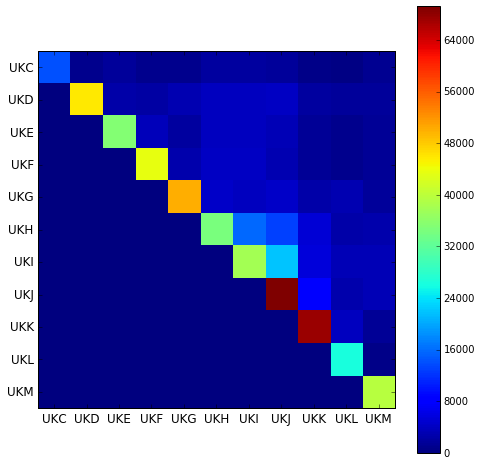

In [138]:
## UKB ALL INTERCONNECTIONS (including self)
mm = ukb_nuts1_corrected_connections_mat
fig,ax = plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(mm,interpolation='nearest',cmap='jet')
ax.set_xticks(np.arange(np.shape(mm)[0]))
ax.set_yticks(np.arange(np.shape(mm)[0]))
ax.set_xticklabels(nuts1_ids,fontsize=12)
ax.set_yticklabels(nuts1_ids,fontsize=12)
plt.colorbar(im)
plt.show()

In [139]:
save_connections('nuts1_corrected_ukb.csv',ukb_nuts1_corrected_connections_dict,centroids)

In [140]:
# clear out region1=region2 in ukb_nuts1_connections_dict dictionary
ukb_nuts1_corrected_interconnections_dict = ukb_nuts1_corrected_connections_dict
for id in nuts1_ids:
    ukb_nuts1_corrected_interconnections_dict[id+','+id] = 0

In [141]:
print(ukb_nuts1_corrected_interconnections_dict)
ukb_nuts1_corrected_interconnections_mat = pairdict_to_mat(ukb_nuts1_corrected_interconnections_dict,nuts1_ids)

{'UKH,UKH': 0, 'UKH,UKJ': 13088.978114501688, 'UKK,UKM': 1601.6733280076819, 'UKD,UKL': 1783.6146739581791, 'UKF,UKM': 1603.6460731632692, 'UKC,UKJ': 1769.2532583133514, 'UKD,UKM': 1748.1142517160063, 'UKG,UKJ': 4326.3907892729376, 'UKG,UKI': 3864.385917547298, 'UKD,UKI': 3971.8492731607848, 'UKI,UKI': 0, 'UKL,UKM': 771.74201266865964, 'UKE,UKJ': 3330.5300613208024, 'UKC,UKM': 1107.746679849276, 'UKG,UKG': 0, 'UKK,UKK': 0, 'UKC,UKC': 0, 'UKD,UKK': 1909.2460592370014, 'UKD,UKG': 3186.7369700634799, 'UKM,UKM': 0, 'UKG,UKL': 3041.1717746720533, 'UKE,UKI': 3835.6621579486, 'UKF,UKF': 0, 'UKK,UKL': 3800.3272344893007, 'UKD,UKH': 3813.8251708810885, 'UKG,UKK': 2664.4515699298167, 'UKF,UKK': 1585.8049443460409, 'UKF,UKH': 4175.7549671249944, 'UKE,UKK': 1552.9740904127975, 'UKJ,UKK': 8350.7711303719734, 'UKE,UKM': 1614.2029196283047, 'UKI,UKJ': 22097.675519607983, 'UKE,UKL': 964.15647119737491, 'UKJ,UKM': 3472.02507169401, 'UKC,UKK': 729.14951817564895, 'UKE,UKF': 3773.6713553927493, 'UKC,UKE'

In [144]:
np.sum(np.sum(ukb_nuts1_corrected_interconnections_mat))
rescale = 21307/192192.09805670148
ukb_nuts1_corrected_interconnections_mat = ukb_nuts1_corrected_interconnections_mat * rescale

21307.0


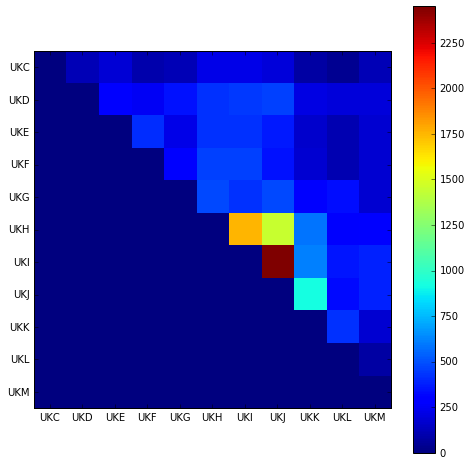

In [146]:
## UKB INTERCONNECTIONS
mm = ukb_nuts1_corrected_interconnections_mat

print(np.sum(np.sum(ukb_nuts1_corrected_interconnections_mat)))
fig,ax = plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(mm,interpolation='nearest')
ax.set_xticks(np.arange(np.shape(mm)[0]))
ax.set_yticks(np.arange(np.shape(mm)[0]))
ax.set_xticklabels(nuts1_ids)
ax.set_yticklabels(nuts1_ids)
plt.colorbar(im)
plt.show()

In [147]:
save_connections('nuts1_corrected_inter_ukb.csv',ukb_nuts1_corrected_interconnections_dict,centroids)

In [131]:
print(len(kinship))
print(np.sum(np.sum(ukb_nuts1_interconnections_mat)))

97692
21307.0
